In [30]:
# import libraries
import pandas as pd
import re
import torch
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import hstack
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Problem Statement and Approach

In light of many GenAI technologies, there are an increasing number of fake job postings getting posted to our job board website which is causing job seekers loose trust in our website and job postings. Identifying fake job postings will be critical for building user trust as well as customer trust.

Job postings are text heavy and Natural Language Processing (NLP) provides an effective method for assessing job posting content. We'll aim to utilize DistilBERT, a transformer-based model to classify job postings. By fine tuning the DistilBERT model on labeled job posting data, our team will aim to build a classification model to deploy to our job search website to detect fake job postings. 

# Data Understanding (EDA)

In [2]:
# Load dataset
df = pd.read_csv('fake_job_postings.csv')

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.columns.tolist()

['job_id',
 'title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent']

In [14]:
# check class balance for fake vs real
class_counts = df['fraudulent'].value_counts()

print(class_counts)

fraudulent
0    17014
1      866
Name: count, dtype: int64


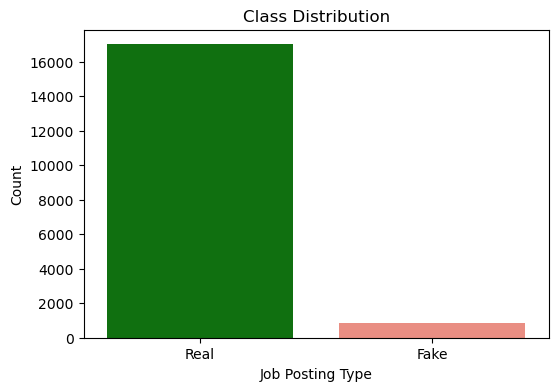

In [19]:
# set class field to string
df['fraudulent'] = df['fraudulent'].astype(str)

# plot class balance
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='fraudulent', hue='fraudulent', palette={'0': 'green', '1': 'salmon'}, legend=False)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Real', 'Fake'])
plt.xlabel('Job Posting Type')
plt.ylabel('Count')
plt.show()

In [9]:
# check for missing data
missing_data = df.isnull().mean().sort_values(ascending=False)

missing_data

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
job_id                 0.000000
telecommuting          0.000000
has_questions          0.000000
has_company_logo       0.000000
title                  0.000000
fraudulent             0.000000
dtype: float64

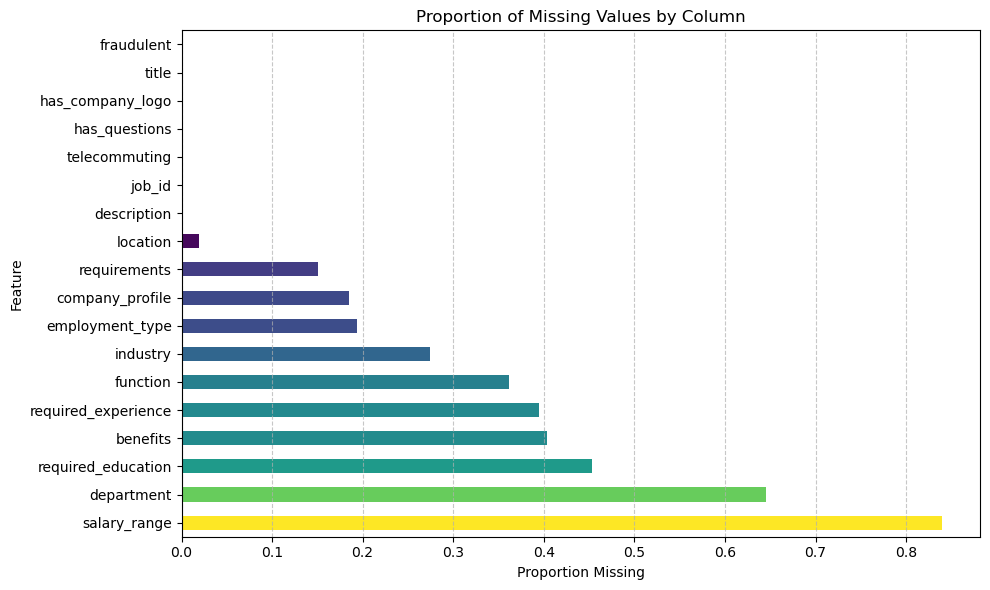

In [22]:
# adding colors to bars for ease of visualization
colors = plt.cm.viridis(missing_data.values / max(missing_data.values))

# plot missing values
plt.figure(figsize=(10, 6))
missing_data.plot(kind='barh', color=colors)
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Proportion Missing')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

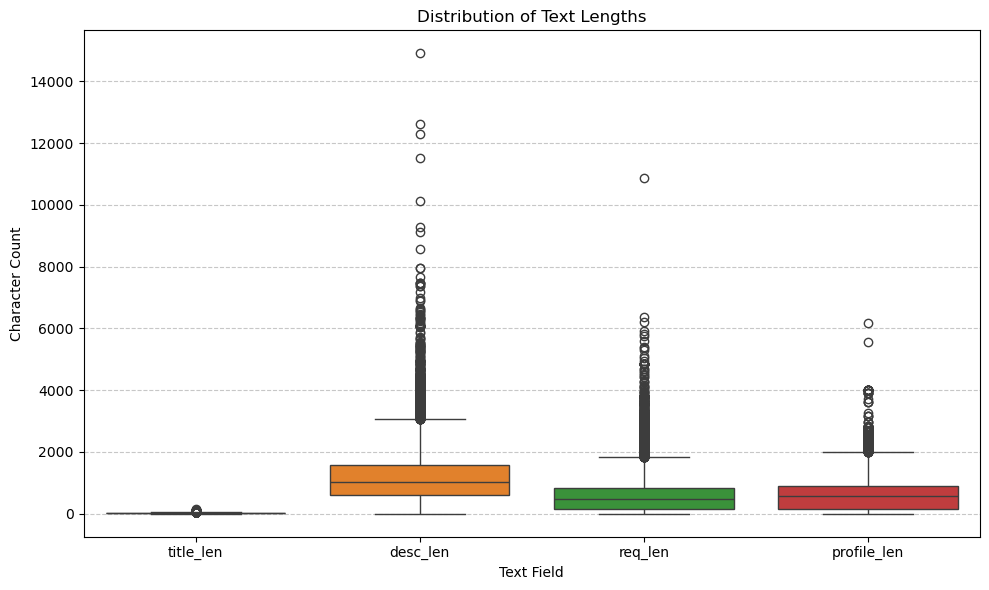

In [24]:
# check text length
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['desc_len'] = df['description'].apply(lambda x: len(str(x)))
df['req_len'] = df['requirements'].apply(lambda x: len(str(x)))
df['profile_len'] = df['company_profile'].apply(lambda x: len(str(x)))

# plot text length
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['title_len', 'desc_len', 'req_len', 'profile_len']])
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Field')
plt.ylabel('Character Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preparation & Feature Engineering

# Feature Selection

# Modeling

In [ ]:
# Stopwords list
stopwords = set([
    "a", "an", "the", "and", "or", "but", "if", "while", "with", "without",
    "in", "on", "at", "to", "from", "by", "for", "of", "as", "is", "are", "was",
    "were", "be", "been", "being", "this", "that", "these", "those", "it", "its",
    "he", "she", "they", "them", "his", "her", "their", "you", "your", "we", "us"
])

In [ ]:
# Clean text
def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r'\b[a-z]{2,}\b', text)
    return ' '.join([t for t in tokens if t not in stopwords])

In [ ]:
# Prepare input text
df['text'] = df[['description', 'requirements', 'company_profile']].fillna('').agg(' '.join, axis=1)
df['clean_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Load Hugging Face model and tokenizer
print("Loading transformer model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")
model.eval()


In [ ]:
# Function to get mean pooled embedding
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Generate embeddings for each job posting
print("Generating embeddings...")
embeddings = np.vstack([get_embedding(text) for text in tqdm(df['clean_text'])])

In [ ]:
# TF-IDF feature extraction
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_text'])

In [ ]:
# LDA topic modeling
print("Running LDA topic modeling...")
count_vectorizer = CountVectorizer(max_features=1000)
count_matrix = count_vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(count_matrix)

In [ ]:
# Combine features
print("Combining features...")
X_combined = hstack([tfidf_features, lda_topics, embeddings])
y = df['fraudulent']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
# Train classifier
print("Training classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
# Predictions and report
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluation

# Deployment

# Discussion and Conclusions